In [1]:
import pystencils as ps
import numpy as np
import sympy as sp
from pystencils import plot as plt
import psutil
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
import matplotlib.animation as animation
from pystencils.boundaries import add_neumann_boundary, Neumann, Dirichlet, BoundaryHandling
from pystencils.slicing import slice_from_direction
import math
import time
%matplotlib inline

In [2]:
dh = ps.create_data_handling(domain_size=(256, 1), periodicity=True)  # able to organize data on 256x256 lattice
μ_field = dh.add_array('mu', latex_name='μ', ghost_layers=2)  # chemical potential (functional derivative of free energy)
c_field = dh.add_array('c', ghost_layers=2)  # raw concentration that free energy depends on

In [3]:
ε, q_0, γ = sp.symbols("ε q_0 γ")

c = c_field.center
μ = μ_field.center

def f(c):
    return -ε*c**2/2 + c**4/4

bulk_free_energy_density = f(c)

covariant_free_energy_density = 1/2 * c**2

grad_sq = sum(ps.fd.diff(c, i)**2 for i in range(dh.dim))
interfacial_free_energy_density = -grad_sq

grad_fourth = sum(ps.fd.diff(ps.fd.diff(c, i), i)**2 for i in range(dh.dim)) + 2*ps.fd.diff(ps.fd.diff(c, 0), 0)*ps.fd.diff(ps.fd.diff(c, 1), 1)
interface_deformation_free_energy_density = 1/2 * grad_fourth

free_energy_density = bulk_free_energy_density + covariant_free_energy_density + interfacial_free_energy_density + interface_deformation_free_energy_density
free_energy_density

c_C**4/4 - c_C**2*ε/2 + 0.5*c_C**2 - Diff(c_C, 0, -1)**2 - Diff(c_C, 1, -1)**2 + 0.5*Diff(Diff(c_C, 0, -1), 0, -1)**2 + 1.0*Diff(Diff(c_C, 0, -1), 0, -1)*Diff(Diff(c_C, 1, -1), 1, -1) + 0.5*Diff(Diff(c_C, 1, -1), 1, -1)**2

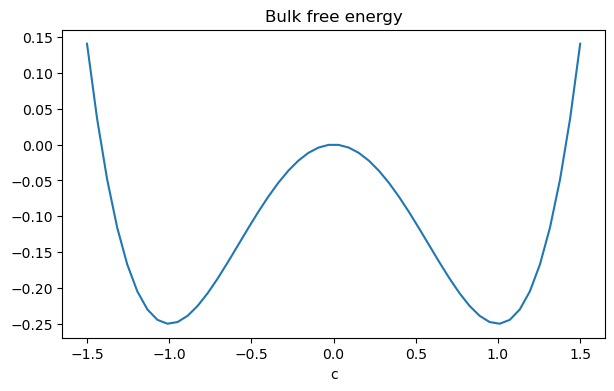

In [4]:
plt.figure(figsize=(7,4))
plt.sympy_function(bulk_free_energy_density.subs(ε, 1), (-1.5, 1.5))
plt.xlabel("c")
plt.title("Bulk free energy");

In [6]:
# here we manually write the update equation for chemical potential μ because 
# Pystencils functional derivative method cannot handle mixed partial derivatives
def bulk_deriv(c):
    return -ε*c + c**3

μ_bulk = bulk_deriv(c)

μ_covariant = c

laplacian = sum(ps.fd.diff(c, i, i) for i in range(dh.dim))
μ_interfacial = 2*laplacian

grad_fourth = sum(ps.fd.diff(c, i, i, i, i) for i in range(dh.dim)) + 2*ps.fd.diff(c, 1, 1, 0, 0)
μ_interface_deformation = grad_fourth

μ_update_eq = μ_bulk + μ_covariant + μ_interfacial + μ_interface_deformation

μ_update_eq

c_C**3 - c_C*ε + c_C + 2*Diff(Diff(c_C, 0, -1), 0, -1) + 2*Diff(Diff(c_C, 1, -1), 1, -1) + Diff(Diff(Diff(Diff(c_C, 0, -1), 0, -1), 0, -1), 0, -1) + 2*Diff(Diff(Diff(Diff(c_C, 0, -1), 0, -1), 1, -1), 1, -1) + Diff(Diff(Diff(Diff(c_C, 1, -1), 1, -1), 1, -1), 1, -1)

In [7]:
'''
It turns out the inbuilt discretization functions neither work for above 2nd order differential equations...
Let's do this part by hand too, and hope it works.
'''

discretize_2ndorderPDEs = ps.fd.Discretization2ndOrder(dx=1, dt=0.002)

μ_interfacial_discretized = discretize_2ndorderPDEs(μ_interfacial)

μ_interfacial_discretized

-8*c_C + 2*c_E + 2*c_N + 2*c_S + 2*c_W

In [8]:
#we must recursively leverage the in-built function for discretizing 2nd order PDEs in order to discretize our 4th order one
second_grad_0 = ps.fd.diff(c,0,0)
second_grad_1 = ps.fd.diff(c,1,1)

second_grad_0_discretized = discretize_2ndorderPDEs(second_grad_0)
second_grad_1_discretized = discretize_2ndorderPDEs(second_grad_1)

fourth_grad_0 = ps.fd.diff(second_grad_0_discretized,0,0)
fourth_grad_0 = ps.fd.expand_diff_linear(fourth_grad_0)
fourth_grad_1 = ps.fd.diff(second_grad_1_discretized,1,1)
fourth_grad_1 = ps.fd.expand_diff_linear(fourth_grad_1)

fourth_grad_0_discretized = discretize_2ndorderPDEs(fourth_grad_0)
fourth_grad_1_discretized = discretize_2ndorderPDEs(fourth_grad_1)


fourth_grad_mixed = ps.fd.diff(second_grad_0_discretized,1,1)
fourth_grad_mixed = ps.fd.expand_diff_linear(fourth_grad_mixed)


fourth_grad_mixed_discretized = 2*discretize_2ndorderPDEs(fourth_grad_mixed)


μ_interface_deformation_discretized = fourth_grad_0_discretized + fourth_grad_1_discretized + fourth_grad_mixed_discretized
μ_interface_deformation_discretized

c_2E + c_2N + c_2S + c_2W + 20*c_C - 8*c_E - 8*c_N + 2*c_NE + 2*c_NW - 8*c_S + 2*c_SE + 2*c_SW - 8*c_W

In [9]:
μ_update_eq_discretized = μ_bulk + μ_covariant + μ_interfacial_discretized + μ_interface_deformation_discretized
μ_update_eq_discretized

c_2E + c_2N + c_2S + c_2W + c_C**3 - c_C*ε + 13*c_C - 6*c_E - 6*c_N + 2*c_NE + 2*c_NW - 6*c_S + 2*c_SE + 2*c_SW - 6*c_W

In [10]:
epsilon = 1
μ_kernel = ps.create_kernel([ps.Assignment(μ_field.center,
                                           μ_update_eq_discretized.subs(ε, epsilon))]
                           ).compile()
# here we define the update function of the chemical potential BEFORE that of yhe concentration

In [11]:
g, M, W, C, S = sp.symbols("g M W C S")

def growth_term(c):
    return g*(sp.tanh(S*(c + W/2 - C))*sp.tanh(S*(W/2 + C - c)) + 1)

c_growth = growth_term(c)
# after suffering through defining the dynamics of the chemical potential, 
# we know full dynamics is just the diffusionary Fick's Law of that + our proposed growth term
swift_hohenberg_growth = ps.fd.transient(c) - ps.fd.diffusion(μ, M) - c_growth  # continuity equation! M is mobility (diffusion) coefficient
swift_hohenberg_growth

-g*(tanh(S*(-c_C + C + W/2))*tanh(S*(c_C - C + W/2)) + 1) - Diffusion(mu_C, M) + Transient(c_C)

In [12]:
# 2nd order discretization of the second derivative, the middle term compounds
c_update = discretize_2ndorderPDEs(swift_hohenberg_growth) 
c_update  # this is the symbolic rule of how c updates

c_C - 0.008*mu_C*M + 0.002*mu_E*M + 0.002*mu_N*M + 0.002*mu_S*M + 0.002*mu_W*M + 0.002*g*tanh(S*(-2*c_C + 2*C + W)/2)*tanh(S*(2*c_C - 2*C + W)/2) + 0.002*g

In [54]:
c_kernel = ps.create_kernel([ps.Assignment(c_field.center,
                                           c_update.subs(M, 1).subs(g,0.05).subs(S,20).subs(W,np.sqrt(epsilon)*1/4).subs(C,np.sqrt(epsilon)*3/4))]
                           ).compile()

In [50]:
# no boundary functions because periodicity was already set in the data handler
def init(value=0.4, noise=0.02):
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each term of iterate
        b['c'].fill(value)
        np.add(b['c'], noise*np.random.rand(*b['c'].shape), out=b['c'])

In [51]:
def init_cell(cells=1, noise=0):
    for b in dh.iterate(ghost_layers=2):
        b['c'].fill(0)
        print(b['c'].shape)
        cell = np.zeros(b['c'].shape)
        cell_line = np.linspace(-cell.shape[0]/2+1,cell.shape[0]/2,cell.shape[0])
        cell_line = np.sqrt(epsilon)*np.cos(cell_line)
        cell_line[int(cell.shape[0]/2 +3*cells):] = -np.sqrt(epsilon)
        cell_line[0:int(cell.shape[0]/2 - 1-3*cells)] = -np.sqrt(epsilon)
        for i in range(cell.shape[1]):
            cell[:,i] = cell_line
        cell = np.add(cell, noise*np.random.rand(*b['c'].shape), out=cell)
        np.add(b['c'], cell, out=b['c'])

In [52]:
def timeloop(steps=100):
    c_sync = dh.synchronization_function(['c'])
    μ_sync = dh.synchronization_function(['mu'])
    for t in range(steps):
        c_sync()
        dh.run_kernel(μ_kernel)  # need chemical potential to update first
        μ_sync()
        dh.run_kernel(c_kernel)  # followed by concentration dynamics from the chemical potential
    return dh.gather_array('c')

(260, 5)
(1000, 260)


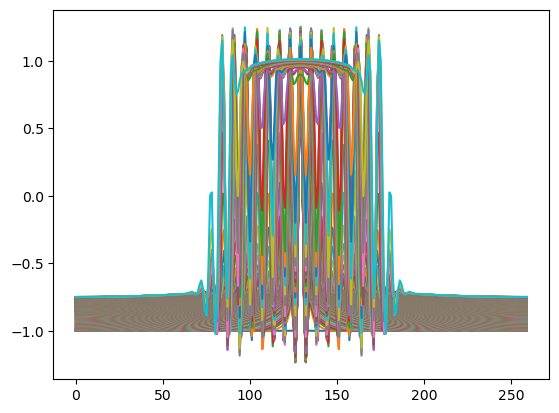

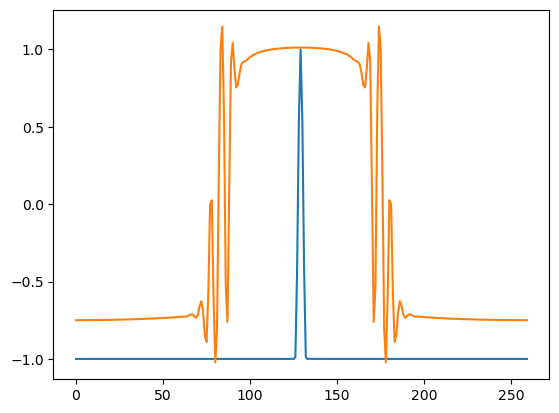

In [59]:
init_cell()
total_steps = 3000000
c_arrs = []
for i in range(total_steps):
    timeloop(steps=1) 
    c_arr = dh.cpu_arrays['c']
    if i%3000==0:
        plt.plot(c_arr[:,2])
        c_arrs.append(c_arr[:,2].copy())

c_arrs = np.array(c_arrs)
print(c_arrs.shape)
plt.show()
plt.plot(c_arrs[0])
plt.plot(c_arrs[999])

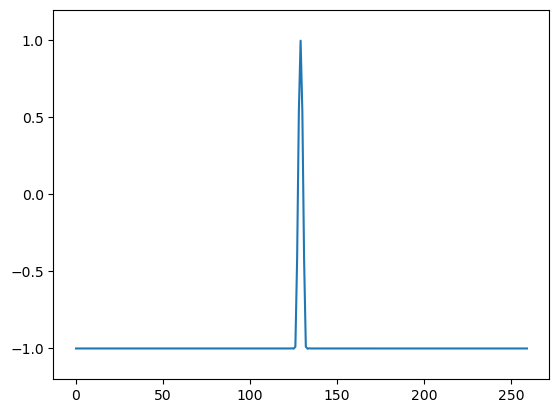

In [60]:
fig,ax = plt.subplots()
line, = ax.plot(np.arange(260),c_arrs[0])
ax.set_ylim(-1.2,1.2)

def animate(i):
    line.set_data(np.arange(260),c_arrs[i])

from matplotlib import animation

anim = animation.FuncAnimation(fig, animate, interval=0.05, frames=999)

anim.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\1D-growth-test.mp4', writer=animation.FFMpegWriter(fps=60))

(260, 5)


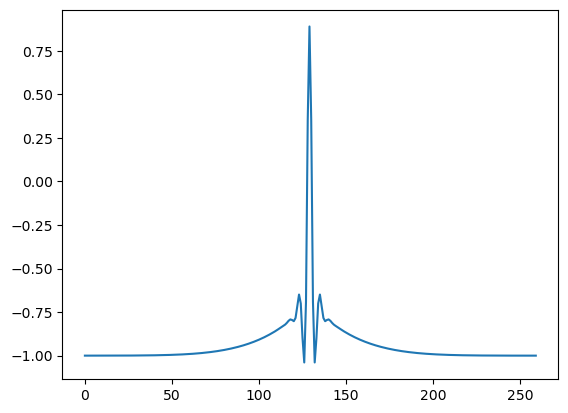

In [56]:
init_cell()
timeloop(steps=100000)
c_arr = dh.cpu_arrays['c']
plt.plot(c_arr[:,2])

[[0.00615259 0.00833477 0.00317795 0.00626263 0.00769851]
 [0.0040672  0.00123053 0.00424846 0.00468995 0.00700467]
 [0.00565754 0.00217132 0.00274735 0.0082328  0.00505725]
 ...
 [0.00234914 0.00134423 0.00859181 0.00673722 0.00225831]
 [0.00649201 0.00622335 0.00673054 0.00689838 0.00581943]
 [0.00244316 0.00615398 0.00517618 0.00616788 0.00604398]]


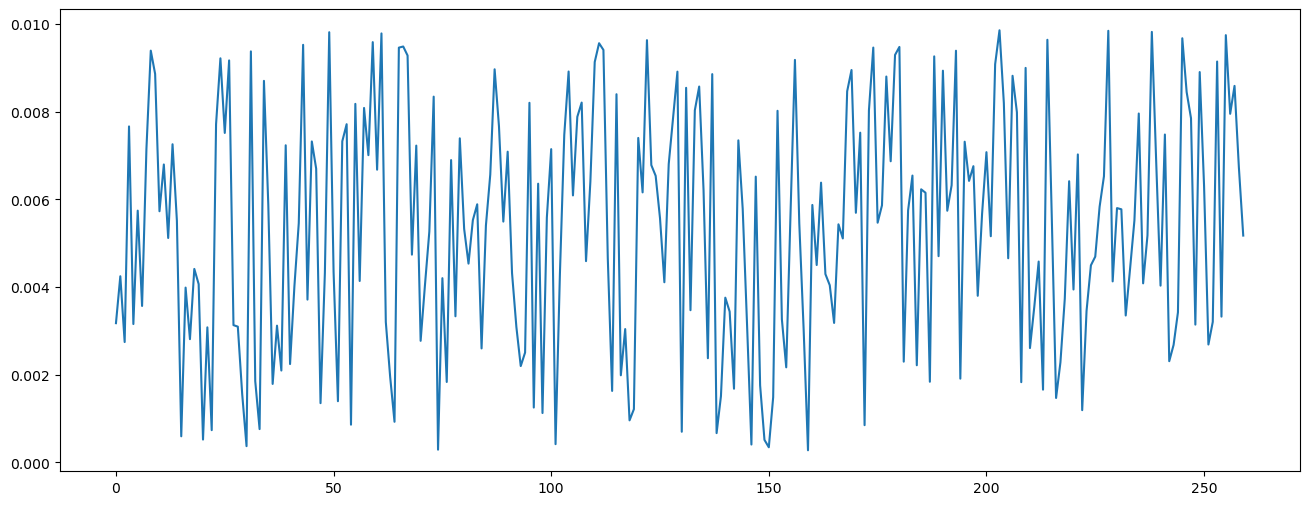

In [40]:
init(0,0.01)
timeloop(steps=500)
c_arr = dh.cpu_arrays['c']
print(c_arr)
plt.plot(c_arr[:,2])

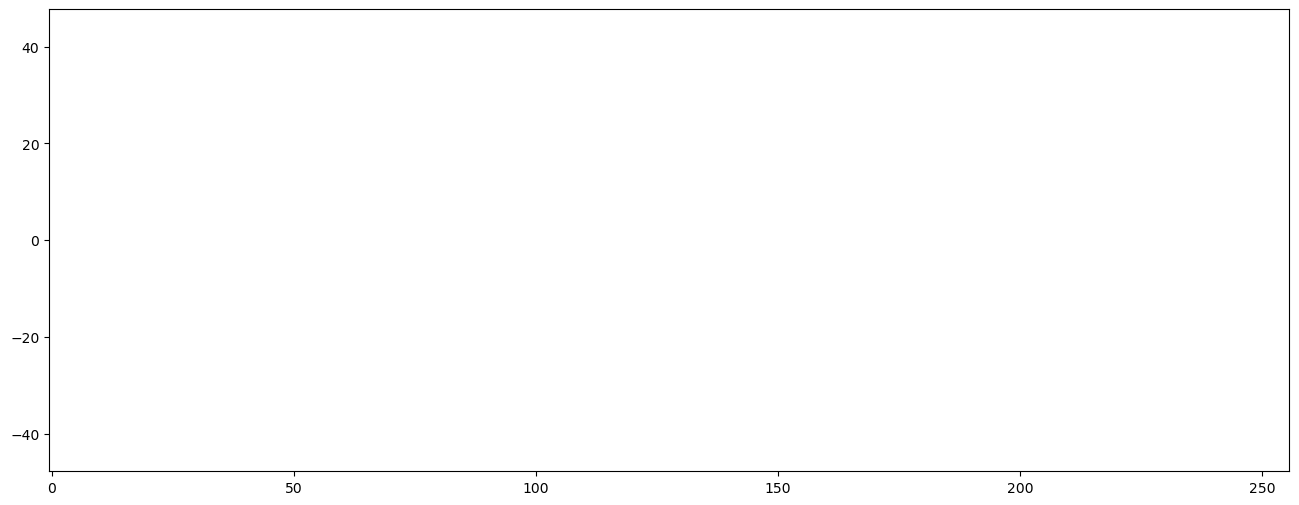

In [17]:
init(0,0.01) # initialize the system at time = 0
# run the simulation and save a video in time
ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=2500)
writervideo = animation.FFMpegWriter(fps=60)
ani.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\1Dswift-hohenberg.mp4', writer=writervideo)